In [2]:
import csv
from io import StringIO
import pandas as pd
import re
import datetime
import numpy as np
import json

from google.cloud import storage

## Load Food.com Recipes

In [4]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('recipe-data-bucket')

blob = bucket.blob('foodcom_recipes.csv')
blob = blob.download_as_string()
blob = blob.decode()
blob = StringIO(blob)  #tranform bytes to string here

df_source = pd.read_csv(blob)
df_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


In [83]:
df_source.head()

name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   
3  ['60-minutes-or-less', 'time-to-make', 'course...   
4  ['weeknight', 'time-to-make', 'course', 'main-...   

                                    nutrition  n_steps  \
0       [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]       11   
1   [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]        9   
2  [269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]        6   
3   [368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]       11   
4   [352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]        5   

                                               steps  \
0  ['make a choice and proceed with recipe', 'dep...   
1  ['preheat oven to 425 degrees f', 'press dough...   
2  ['brown ground beef in large pot', 'add choppe...   
3  ['place potatoes in a large pot of lightly sal...   
4  ['mix all ingredients& boil for 2 1 / 2 hours ...   

                                         description  \
0  autumn is my favorite time of year to cook! th...   
1  this recipe calls for the crust to be prebaked...   
2  this modified version of 'mom's' chili was a h...   
3  this is a super easy, great tasting, make ahea...   
4  my dh's amish mother raised him on this recipe...   

                                         ingredients  n_ingredients  
0  ['winter squash', 'mexican seasoning', 'mixed ...              7  
1  ['prepared pizza crust', 'sausage patty', 'egg...              6  
2  ['ground beef', 'yellow onions', 'diced tomato...             13  
3  ['spreadable cheese with garlic and herbs', 'n...             11  
4  ['tomato juice', 'apple cider vinegar', 'sugar...              8

No ingredient units, so this dataset can't be used.

## Load Epicurious Recipes

In [3]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('recipe-data-bucket')

blob = bucket.blob('epicurious_recipes.json')
blob = blob.download_as_string()
data = json.loads(blob)

df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20130 entries, 0 to 20129
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   directions   20111 non-null  object 
 1   fat          15908 non-null  float64
 2   date         20111 non-null  object 
 3   categories   20111 non-null  object 
 4   calories     15976 non-null  float64
 5   desc         13495 non-null  object 
 6   protein      15929 non-null  float64
 7   rating       20100 non-null  float64
 8   title        20111 non-null  object 
 9   ingredients  20111 non-null  object 
 10  sodium       15974 non-null  float64
dtypes: float64(5), object(6)
memory usage: 1.7+ MB


Since the data doesn't have carbs, we will compute it using the standard 4/4/9 rule: $calories = 9*fat + 4*carbs + 4*protein$.

In [4]:
df['carbs'] = (df['calories'] - df['fat']*9 - df['protein']*4) / 4
df.head()

directions   fat  \
0  [1. Place the stock, lentils, celery, carrot, ...   7.0   
1  [Combine first 9 ingredients in heavy medium s...  23.0   
2  [In a large heavy saucepan cook diced fennel a...   7.0   
3  [Heat oil in heavy large skillet over medium-h...   NaN   
4  [Preheat oven to 350°F. Lightly grease 8x8x2-i...  32.0   

                       date  \
0  2006-09-01T04:00:00.000Z   
1  2004-08-20T04:00:00.000Z   
2  2004-08-20T04:00:00.000Z   
3  2009-03-27T04:00:00.000Z   
4  2004-08-20T04:00:00.000Z   

                                          categories  calories  \
0  [Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...     426.0   
1  [Food Processor, Onion, Pork, Bake, Bastille D...     403.0   
2  [Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...     165.0   
3  [Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...       NaN   
4  [Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...     547.0   

                                                desc  protein  rating  \
0                                               None     30.0   2.500   
1  This uses the same ingredients found in boudin...     18.0   4.375   
2                                               None      6.0   3.750   
3  The Sicilian-style tomato sauce has tons of Me...      NaN   5.000   
4                                               None     20.0   3.125   

                                         title  \
0              Lentil, Apple, and Turkey Wrap    
1  Boudin Blanc Terrine with Red Onion Confit    
2                Potato and Fennel Soup Hodge    
3             Mahi-Mahi in Tomato Olive Sauce    
4                    Spinach Noodle Casserole    

                                         ingredients  sodium  carbs  
0  [4 cups low-sodium vegetable or chicken stock,...   559.0  60.75  
1  [1 1/2 cups whipping cream, 2 medium onions, c...  1439.0  31.00  
2  [1 fennel bulb (sometimes called anise), stalk...   165.0  19.50  
3  [2 tablespoons extra-virgin olive oil, 1 cup c...     NaN    NaN  
4  [1 12-ounce package frozen spinach soufflé, th...   452.0  44.75

In [5]:
cols = ['title', 'desc', 'categories', 'ingredients', 'calories', 'carbs', 'fat', 'protein', 'sodium', 'directions']
df = df[cols]
df.head()

title  \
0              Lentil, Apple, and Turkey Wrap    
1  Boudin Blanc Terrine with Red Onion Confit    
2                Potato and Fennel Soup Hodge    
3             Mahi-Mahi in Tomato Olive Sauce    
4                    Spinach Noodle Casserole    

                                                desc  \
0                                               None   
1  This uses the same ingredients found in boudin...   
2                                               None   
3  The Sicilian-style tomato sauce has tons of Me...   
4                                               None   

                                          categories  \
0  [Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...   
1  [Food Processor, Onion, Pork, Bake, Bastille D...   
2  [Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...   
3  [Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...   
4  [Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...   

                                         ingredients  calories  carbs   fat  \
0  [4 cups low-sodium vegetable or chicken stock,...     426.0  60.75   7.0   
1  [1 1/2 cups whipping cream, 2 medium onions, c...     403.0  31.00  23.0   
2  [1 fennel bulb (sometimes called anise), stalk...     165.0  19.50   7.0   
3  [2 tablespoons extra-virgin olive oil, 1 cup c...       NaN    NaN   NaN   
4  [1 12-ounce package frozen spinach soufflé, th...     547.0  44.75  32.0   

   protein  sodium                                         directions  
0     30.0   559.0  [1. Place the stock, lentils, celery, carrot, ...  
1     18.0  1439.0  [Combine first 9 ingredients in heavy medium s...  
2      6.0   165.0  [In a large heavy saucepan cook diced fennel a...  
3      NaN     NaN  [Heat oil in heavy large skillet over medium-h...  
4     20.0   452.0  [Preheat oven to 350°F. Lightly grease 8x8x2-i...

In [107]:
import plotly.express as px

In [117]:
cal_dist = px.violin(df['calories'], orientation='h')
cal_dist.update_layout(title='Distribution of Calories Across Recipes', xaxis_title='', yaxis_title='')

In [118]:
carb_dist = px.violin(df['carbs'], orientation='h')
carb_dist.update_layout(title='Distribution of Carbs Across Recipes', xaxis_title='', yaxis_title='')

In [119]:
protein_dist = px.violin(df['protein'], orientation='h')
protein_dist.update_layout(title='Distribution of Protein Across Recipes', xaxis_title='', yaxis_title='')

In [120]:
fat_dist = px.violin(df['fat'], orientation='h')
fat_dist.update_layout(title='Distribution of Fat Across Recipes', xaxis_title='', yaxis_title='')

In [121]:
sodium_dist = px.violin(df['sodium'], orientation='h')
sodium_dist.update_layout(title='Distribution of Sodium Across Recipes', xaxis_title='', yaxis_title='')

There is clearly a data quality issue as there shouldn't be recipes yielding 30 million calories. 

In [146]:
df[df['calories'] > 5000]

title  \
334            Ginger Crunch Cake with Strawberry Sauce    
567              Apple, Pear, and Cranberry Coffee Cake    
772                               Birthday Party Paella    
862    Roast Goose with Garlic, Onion and Sage Stuffing    
1308         Rice Pilaf with Lamb, Carrots, and Raisins    
...                                                  ...   
18836                       Pear Cake with Grappa Sauce    
19270           Grilled Lamb Chops with Porcini Mustard    
19349  Vanilla-Buttermilk Cake With Raspberries and O...   
19424  Lamb Chops with Everything-Bagel Yogurt and Ch...   
19749                 Apricot, Cranberry and Walnut Pie    

                                                    desc  \
334                                                 None   
567    We like to bake with a combination of apples: ...   
772    Do-ahead tips make this rendition of the Spani...   
862                                                 None   
1308   This lamb-rich, Uzbek-style pilaf is typical o...   
...                                                  ...   
18836                                               None   
19270  Rubbed all over with a mixture of garlic, fres...   
19349  This tender buttermilk cake with rich orange c...   
19424  Splurge on lamb rib chops or save on loin chop...   
19749                                               None   

                                              categories  \
334    [Cake, Milk/Cream, Food Processor, Mixer, Ging...   
567    [Cake, Dessert, Thanksgiving, Wheat/Gluten-Fre...   
772    [Chicken, Garlic, Rice, Bake, Sauté, Sausage, ...   
862    [Chicken, Garlic, Onion, Roast, Sauté, Christm...   
1308   [Lamb, Rice, Vegetable, Braise, Dinner, Raisin...   
...                                                  ...   
18836  [Cake, Dairy, Egg, Fruit, Dessert, Bake, Pear,...   
19270  [Lamb, Mushroom, Mustard, Quick & Easy, Father...   
19349  [#CAKEWEEK, Cake, Buttermilk, Bake, Wedding, R...   
19424  [Lamb, Kid-Friendly, Yogurt, Lamb Chop, Chickp...   
19749  [Berry, Fruit, Nut, Dessert, Bake, Thanksgivin...   

                                             ingredients    calories  \
334    [1 cup pecans, toasted and chopped fine, 1/2 c...      6841.0   
567    [1 cup oats, 3/4 cup white rice flour, 1 cup b...      5090.0   
772    [3 tablespoons olive oil, 6 fresh Cajun or hot...      7141.0   
862    [1/4 cup (1/2 stick) unsalted butter, 2 small ...      8603.0   
1308   [3 cups basmati rice (7 ounces), 1 medium onio...   4157357.0   
...                                                  ...         ...   
18836  [1 1/4 cups plus 2 tablespoons all-purpose flo...      5203.0   
19270  [2 ounces dried porcini mushrooms, 2 cups boil...     24117.0   
19349  [Nonstick vegetable oil spray, 2 cups cake flo...      7202.0   
19424  [7 tablespoons olive oil, divided, 2 1/2 teasp...      5578.0   
19749  [1 cup (packed) golden brown sugar, 2 large eg...  13062948.0   

            carbs       fat   protein      sodium  \
334        613.25     460.0      62.0      3491.0   
567        718.75     219.0      61.0      2253.0   
772        100.25     540.0     470.0      6152.0   
862         61.00     923.0      13.0      1401.0   
1308    304486.50  221495.0  236489.0   3134853.0   
...           ...       ...       ...         ...   
18836      626.25     270.0      67.0       809.0   
19270       76.25    2228.0     940.0      4382.0   
19349      732.50     436.0      87.0      3923.0   
19424       50.75     503.0     212.0      2064.0   
19749  1496957.50  747374.0   87188.0  12005810.0   

                                              directions  
334    [Preheat oven to 350°F. Grease three 8- by 2-i...  
567    [Combine all streusel ingredients in a bowl an...  
772    [Heat 1 tablespoon oil in heavy large shallow ...  
862    [Melt butter in heavy large skillet over mediu...  
1308   [Wash rice in several changes of cold water in...  
...                             

In [142]:
print(df[df['calories'] > 5000].iloc[-1]['calories'])
print()
print(df[df['calories'] > 5000].iloc[-1]['ingredients'])
print()
print(df[df['calories'] > 5000].iloc[-1]['directions'])

13062948.0

['1 cup (packed) golden brown sugar', '2 large eggs', '1 teaspoon vanilla extract', '1/4 cup whipping cream', '3 tablespoons unsalted butter, melted', '3/4 teaspoon ground cinnamon', '1/4 teaspoon salt', '1 1/2 cups coarsely chopped walnuts', '1 1/2 cups dried apricots (about 8 ounces), cut into 1/2-inch pieces', '1 cup dried cranberries', 'epi:recipeLink id="102546"<1 Flaky Pie Crust>/epi:recipeLink<', 'Additional dried apricots, dried cranberries and walnuts (for garnish)']

['Position rack in center of oven and preheat to 375°F. Whisk brown sugar, eggs and vanilla extract in large bowl to blend. Whisk in cream, melted butter, cinnamon and salt. Stir in chopped walnuts, apricot pieces and 1 cup cranberries.', 'Transfer filling to prepared crust. Bake until filling is set and crust is golden, tenting pie with foil if crust browns too quickly, about 1 hour. Transfer pie to rack; cool pie completely. (Can be prepared 1 day ahead. Cover pie and store at room temperature.)', '

In [143]:
print(df[df['calories'] > 5000].iloc[-6]['calories'])
print()
print(df[df['calories'] > 5000].iloc[-6]['ingredients'])
print()
print(df[df['calories'] > 5000].iloc[-6]['directions'])

6361.0

['3/4 teaspoon cinnamon', '4 (1-inch-thick) lamb shoulder chops', '1 to 2 garlic cloves', '2cups flat-leaf parsley including trimmed stems', '2 cups mint including trimmed stems', '1/3 cup distilled white vinegar', '1/2 cup extra-virgin olive oil', '1 (10-ounces) package frozen peas', '3 tablespoons water', '2 tablespoons unsalted butter']

['Preheat broiler.', 'Stir together cinnamon and 11/2 teaspoon each of salt and pepper in a bowl, then rub over chops. Broil in a 4-sided sheet pan 3 to 4 inches from heat, turning once, 8 to 10 minutes total for medium-rare.', 'With motor running, drop garlic into food processor and finely chop. Add remaining sauce ingredients and 1/2 teaspoon salt and pulse until herbs are finely chopped. Transfer to a bowl.', 'Cook peas in water and butter in a small saucepan over medium-high heat, covered, stirring once or twice, until just tender, about 3 minutes.', 'Serve chops drizzled with a little chimichurri and serve peas and remaining chimichurri

In [144]:
print(df[df['calories'] > 5000].iloc[10]['calories'])
print()
print(df[df['calories'] > 5000].iloc[10]['ingredients'])
print()
print(df[df['calories'] > 5000].iloc[10]['directions'])

6929.0

['2 1/3 cups, scooped and leveled, plus 1 tablespoon/300g all-purpose flour', '3/4 cup/150g plus 1 tablespoon granulated sugar, divided', '1 teaspoon baking powder', 'Pinch of salt', '10 1/2 tablespoons/150g unsalted high-fat, European-style butter, softened', '1 egg, at room temperature', '6 large apples (2 pounds 10 ounces/1.2kg)', 'Juice of 1 lemon plus 2 teaspoons freshly squeezed lemon juice', '1 1/4 teaspoon Lebkuchen Spice Mix', '1 cup fresh cranberries', '1/4 cup/60ml plus 2 teaspoons water', '3/4 cup/75g confectioners’ sugar']

['Mix the flour, 3/4 cup granulated sugar, baking powder, and salt together in a large bowl. Cut the butter into cubes and add to the flour mixture. Using a pastry cutter or your hands, work the butter into the flour until it’s no longer visible. Add the egg and knead until the dough is smooth. Wrap tightly in plastic wrap and refrigerate for at least 1 hour and up to 24 hours.', 'Peel, core, and quarter the apples. Cut them into slices 1/8 to 1

As shown above, a recipe that calls for 3 tbps of butter as the main fat source can't have 13 million calories. Let's get rid of all recipes with more than 2,000 calories.

In [6]:
df = df[df['calories'] < 2000].reset_index(drop=True)
df.sort_values('calories', ascending=False)

title  \
12110  Caramel Mousse Napoleon with Caramel Sauce and...   
7277   Pizza with Roasted Garlic, Bell Peppers and Tw...   
15578                  Noreen Kinney's Irish Soda Bread    
8944           Grilled Chicken Breasts in Spiced Yogurt    
11328               Peppercorn- and Thyme-Roasted Goose    
...                                                  ...   
12545                      Cashew Milk and Cashew Flour    
4786                         Dashi (Japanese Sea Stock)    
5385                                Tempering Chocolate    
8390                           Salted Water for Boiling    
224                            Salted Water for Boiling    

                                                    desc  \
12110                                               None   
7277                                                None   
15578  Editor's note: The recipe and introductory tex...   
8944         Active time: 15 min Start to finish: 35 min   
11328                                               None   
...                                                  ...   
12545  Editor's note: The recipe and introductory tex...   
4786   Kombu comes packaged in dried lengths that are...   
5385   Editor's note: The recipe below is excerpted f...   
8390                                                None   
224                                                 None   

                                              categories  \
12110  [Milk/Cream, Berry, Dairy, Fruit, Dessert, Bak...   
7277   [Garlic, Pepper, Bake, Vegetarian, Kid-Friendl...   
15578  [Bread, Breakfast, Side, Bake, St. Patrick's D...   
8944   [Chicken, Marinate, Low Carb, Quick & Easy, Yo...   
11328  [Poultry, Roast, Thanksgiving, Dinner, Goose, ...   
...                                                  ...   
12545                                [Nut, No-Cook, Raw]   
4786                        [Soup/Stew, Spring, Gourmet]   
5385                              [Chocolate, Christmas]   
8390                                     [Boil, Gourmet]   
224                                      [Boil, Gourmet]   

                                             ingredients  calories   carbs  \
12110  [1 17.3-ounce package frozen puff pastry (2 sh...    1993.0  135.75   
7277   [1 large head garlic, unpeeled, 2 tablespoons ...    1990.0   34.00   
15578  [1 3/4 cups unbleached all-purpose flour, 1 cu...    1986.0  256.75   
8944   [2 1/4 cups plain yogurt (18 oz; preferably wh...    1985.0   20.75   
11328  [3 tablespoons mixed cracked black, white, and...    1982.0   11.25   
...                                                  ...       ...     ...   
12545  [3 cups raw cashews, soaked for 10 to 12 hours...       0.0     NaN   
4786   [6 cups cold water, 1 oz (30 grams) kombu (dri...       0.0    0.00   
5385   [Bittersweet, semisweet, milk, or white chocol...       0.0    0.00   
8390                                       [Salt, Water]       0.0     NaN   
224                                        [Salt, Water]       0.0     NaN   

         fat  protein  sodium  \
12110  154.0     16.0   302.0   
7277   194.0     27.0   997.0   
15578   75.0     71.0  5753.0   
8944   110.0    228.0  1537.0   
11328  181.0     77.0   659.0   
...      ...      ...     ...   
12545    NaN      NaN     0.0   
4786     0.0      0.0    26.0   
5385     0.0      0.0     0.0   
8390     NaN      NaN     0.0   
224      NaN      NaN     0.0   

                                              directions  
12110  [Position 1 rack in top third and 1 rack in bo...  
7277   [Preheat oven to 375°F. Slice top off garlic h...  
15578  [Adjust an oven rack to the center position an...  
8944   [Whisk together 1 cup yogurt, 2 tablespoons oi...  
11328  [To prepare the glaze: Stir together the crack...  
...                                                  ...  
12545  [To make the milk: In a high-speed blender, co...  
4786   [Bring cold water and kombu just to a boil in ...  
5385   [Tempering deter

Let's take a look at the common categories.

In [7]:
import wordcloud
import matplotlib.pyplot as plt

In [157]:
cats = df['categories'].sum()
cat_freqs = {}
for cat in cats:
    if cat in cat_freqs:
        cat_freqs[cat] += 1
    else:
        cat_freqs[cat] = 1

(-0.5, 799.5, 399.5, -0.5)

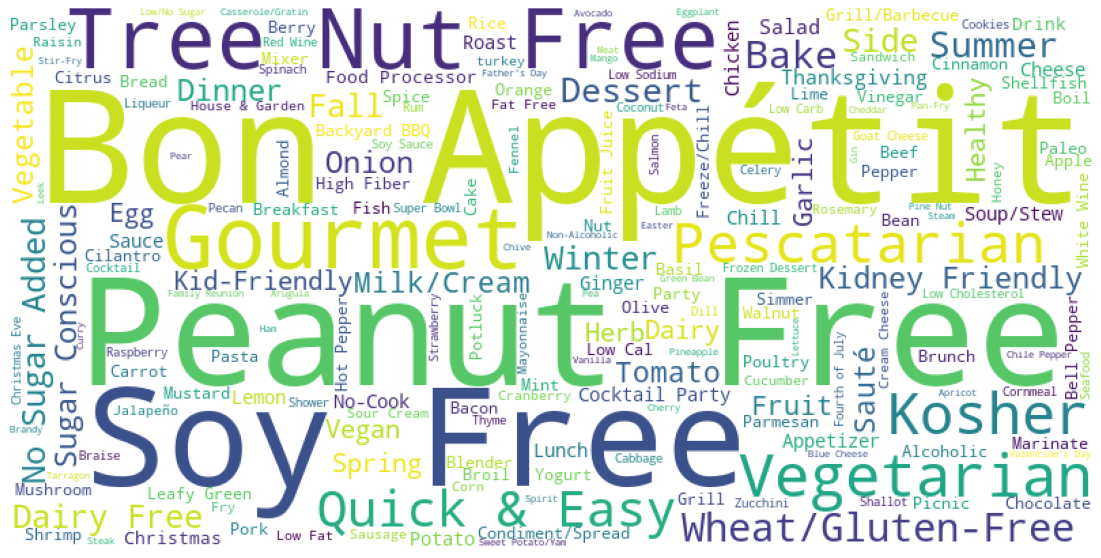

In [169]:
wc = wordcloud.WordCloud(background_color='white', width=800, height=400)
wc.generate_from_frequencies(cat_freqs)
plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')

Let's also look at the common key words that appear across titles.

In [18]:
titles = df['title'].values.tolist()
keywords_in_titles = [w.strip() for w in sum([t.split() for t in titles], [])]
keywords_in_titles = [re.sub(r'\W+', '', w) for w in keywords_in_titles]
kw_freqs = {}
for w in keywords_in_titles:
    if w in kw_freqs:
        kw_freqs[w] += 1
    else:
        kw_freqs[w] = 1

(-0.5, 799.5, 399.5, -0.5)

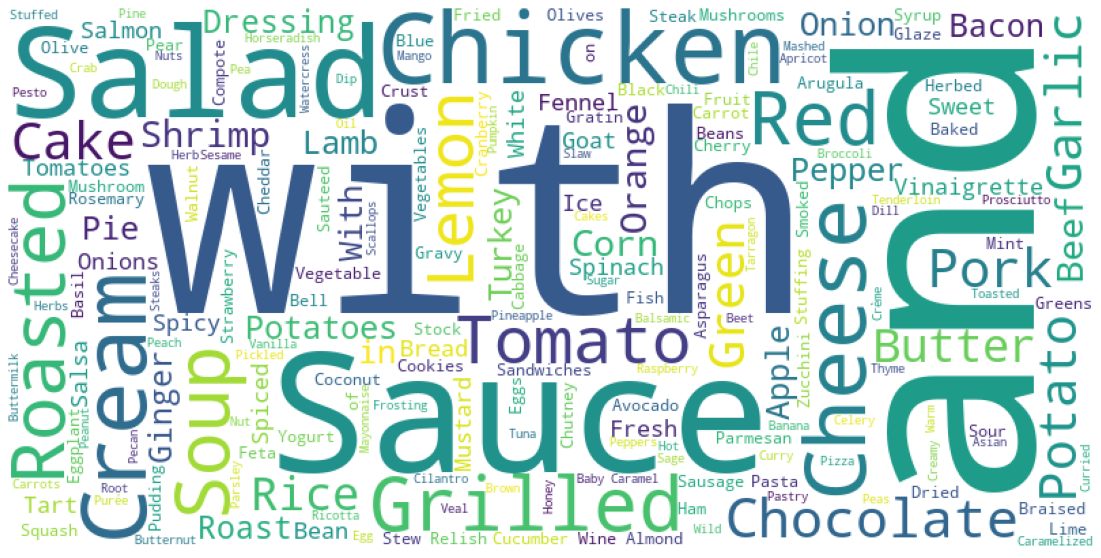

In [20]:
wc = wordcloud.WordCloud(background_color='white', width=800, height=400)
wc.generate_from_frequencies(kw_freqs)
plt.figure(figsize=(20, 10))
plt.imshow(wc)
plt.axis('off')

## NER Ingredient Parsing

Now, let's use [this](https://huggingface.co/edwardjross/xlm-roberta-base-finetuned-recipe-all?text=1%2F2+teaspoon+fresh+thyme%2C+minced) NER model to extract name, state, unit, quantity, size from an ingredient string.

In [26]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("token-classification", model="edwardjross/xlm-roberta-base-finetuned-recipe-all")

In [98]:
def parse_ingredients(ingredients):
    names = []
    states = []
    units = []
    quantities = []
    sizes = []
    temps = []
    dfs = []
    for i in ingredients:
        ner = pipe(i)
        n = ''
        s = ''
        u = ''
        q = ''
        si = ''
        t = ''
        df = ''

        for entity in ner:
            if entity['entity'] == 'I-QUANTITY':
                q += entity['word']
            if entity['entity'] == 'I-NAME':
                n += entity['word']
            if entity['entity'] == 'I-STATE':
                s += entity['word']
            if entity['entity'] == 'I-DF':
                df += entity['word']
            if entity['entity'] == 'I-UNIT':
                u += entity['word']
            if entity['entity'] == 'I-SIZE':
                si += entity['word']
            if entity['entity'] == 'I-TEMP':
                t += entity['word']
        
        n = ' '.join(n.split('▁')).strip()
        s = ' '.join(s.split('▁')).strip()
        u = ' '.join(u.split('▁')).strip()
        q = ' '.join(q.split('▁')).strip()
        t = ' '.join(t.split('▁')).strip()
        si = ' '.join(si.split('▁')).strip()
        df = ' '.join(df.split('▁')).strip()
        

        names.append(n)
        states.append(s)
        units.append(u)
        quantities.append(q)
        sizes.append(si)
        temps.append(t)
        dfs.append(df)

    
    return pd.Series([names, states, units, quantities, sizes, temps, dfs])

In [100]:
df_parsed_ingredients = df['ingredients'].apply(parse_ingredients).rename(columns={0: 'ingredients_names', 1: 'ingredients_states', 2: 'ingredients_units', 3: 'ingredients_quantities', 4: 'ingredients_sizes', 5: 'ingredients_temps', 6: 'ingredients_dfs'})
df_parsed_ingredients.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15636 entries, 0 to 15635
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ingredients_names       15636 non-null  object
 1   ingredients_states      15636 non-null  object
 2   ingredients_units       15636 non-null  object
 3   ingredients_quantities  15636 non-null  object
 4   ingredients_sizes       15636 non-null  object
 5   ingredients_temps       15636 non-null  object
 6   ingredients_dfs         15636 non-null  object
dtypes: object(7)
memory usage: 855.2+ KB


In [106]:
df = df.merge(df_parsed_ingredients, left_index=True, right_index=True)
df.head()

title  \
0              Lentil, Apple, and Turkey Wrap    
1  Boudin Blanc Terrine with Red Onion Confit    
2                Potato and Fennel Soup Hodge    
3                    Spinach Noodle Casserole    
4                               The Best Blts    

                                                desc  \
0                                               None   
1  This uses the same ingredients found in boudin...   
2                                               None   
3                                               None   
4  This recipe can be prepared in 45 minutes or l...   

                                          categories  \
0  [Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...   
1  [Food Processor, Onion, Pork, Bake, Bastille D...   
2  [Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...   
3  [Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...   
4  [Sandwich, Food Processor, Tomato, Kid-Friendl...   

                                         ingredients  calories  carbs   fat  \
0  [4 cups low-sodium vegetable or chicken stock,...     426.0  60.75   7.0   
1  [1 1/2 cups whipping cream, 2 medium onions, c...     403.0  31.00  23.0   
2  [1 fennel bulb (sometimes called anise), stalk...     165.0  19.50   7.0   
3  [1 12-ounce package frozen spinach soufflé, th...     547.0  44.75  32.0   
4  [2 1/2 cups (lightly packed) fresh basil leave...     948.0  40.25  79.0   

   protein  sodium                                         directions  \
0     30.0   559.0  [1. Place the stock, lentils, celery, carrot, ...   
1     18.0  1439.0  [Combine first 9 ingredients in heavy medium s...   
2      6.0   165.0  [In a large heavy saucepan cook diced fennel a...   
3     20.0   452.0  [Preheat oven to 350°F. Lightly grease 8x8x2-i...   
4     19.0  1042.0  [Mix basil, mayonnaise and butter in processor...   

                                   ingredients_names  \
0  [vegetable, brown lentils, French green lentil...   
1  [whipping cream, onions, salt, bay leaves, clo...   
2  [fennel bulb ani, onion, ted butter, russet po...   
3  [spinach soufflé, extra egg noodles, cream, pe...   
4  [basil leaves, mayonnaise, butter, bacon strip...   

                                  ingredients_states  \
0  [lowsodium, , , chopped, peeled chopped, , , c...   
1  [, chopped, , , , crush, , ground, crumble, mi...   
2                             [, diced, unsal, , , ]   
3        [thawed, cook, sour, purchase, ground, gra]   
4  [pack, , , slice, , cut, rip pitted peeled sli...   

                                   ingredients_units  \
0  [cups, cup, cup, stalks, , sprig, teaspoon, , ...   
1  [cups, , teaspoons, , , clove, teaspoon, teasp...   
2                    [, , tablespoons, , cups, cups]   
3  [ounce package, pound, cup, tablespoons, teasp...   
4       [cups, cup, cup, s pound, in slices, , , , ]   

                              ingredients_quantities  \
0  [4, 1, 1/2, 2, 1, 1, 1, 1, 1, 1, 2, , 3, 3/4, ...   
1  [1 1/2, 2, 5, 3, 3, 1, 1, 1/8, , 8, 1, 1, 3, 6...   
2                             [1, 1, 2, 2, 2, 1 1/2]   
3                         [1 12-, 1/2, 1, 2, 1/4, 1]   
4          [2 1/2, 1, 1/4, 12 1, 12 1/2, 3, 2, 1, 6]   

                                   ingredients_sizes  \
0     [, , , , large, , , medium, small, , , , , , ]   
1  [, medium, , , , large, , , , large, , , , , ,...   
2                                 [, , , medium, , ]   
3                                       [, , , , , ]   
4                            [, , , , , large, , , ]   

                                   ingredients_temps  \
0                     [, , , , , , , , , , , , , , ]   
1  [, , , , , , , , , , , , , , , , , , , , , , ,...   
2                                       [, , , , , ]   
3                                 [frozen, , , , , ]   
4                                 [, , , , , , , , ]   

                                     ingredients_dfs  
0  [, dried, dried, , , fresh, , , , fresh, , Fre...  
1  [, , , , , , , , 

In [110]:
# upload to GCS
storage_client = storage.Client()
bucket = storage_client.get_bucket('recipe-data-bucket')

blob = bucket.blob('foodcom_recipes_NER.csv')

csv_buffer = StringIO()
df.to_csv(csv_buffer, index=False)
blob.upload_from_string(csv_buffer.getvalue())

## Quality Control

Now, we will load the data with NER components (produced above) and nutrition facts provided are accurate. We will use the [CalorieNinja API](https://calorieninjas.com/api) to extract nutrition facts given a list of ingredients.

In [118]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('recipe-data-bucket')

blob = bucket.blob('foodcom_recipes_NER.csv')
blob = blob.download_as_string()
blob = blob.decode()
blob = StringIO(blob)  #tranform bytes to string here

df = pd.read_csv(blob)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15636 entries, 0 to 15635
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   15636 non-null  object 
 1   desc                    10408 non-null  object 
 2   categories              15636 non-null  object 
 3   ingredients             15636 non-null  object 
 4   calories                15636 non-null  float64
 5   carbs                   15565 non-null  float64
 6   fat                     15568 non-null  float64
 7   protein                 15589 non-null  float64
 8   sodium                  15634 non-null  float64
 9   directions              15636 non-null  object 
 10  ingredients_names       15636 non-null  object 
 11  ingredients_states      15636 non-null  object 
 12  ingredients_units       15636 non-null  object 
 13  ingredients_quantities  15636 non-null  object 
 14  ingredients_sizes       15636 non-null

In [59]:
from ast import literal_eval
import requests
from tqdm import tqdm

In [71]:
def get_list_of_ingredient_names_quantities(row):
    names = literal_eval(row['ingredients_names'])
    quantities = literal_eval(row['ingredients_quantities'])
    units = literal_eval(row['ingredients_units'])
    return [f'{n} {q}{u}' for n, q, u in zip(names, quantities, units)]

def calorie_ninja_req(query, key):
    api_url = 'https://api.calorieninjas.com/v1/nutrition?query='
    response = requests.get(api_url + query, headers={'X-Api-Key': key})
    if response.status_code == requests.codes.ok:
        return response.text
    else:
       return f"Error {response.status_code}: {response.text}"

def get_ground_truth_nutrition(row, calorie_ninja_api_key='JVcHQQVCewamlHI4iQaj9w==F6sGcOgmjrDcW6XQ'):
    ingredients = get_list_of_ingredient_names_quantities(row)
    ingredients_str = ', '.join(ingredients)

    resp = calorie_ninja_req(ingredients_str, calorie_ninja_api_key)
    try:
        resp = json.loads(resp)
    except json.JSONDecodeError:
        return resp
    calories = 0
    protein = 0
    fat = 0
    carbs = 0
    sodium = 0

    for item in resp['items']:
        calories += item['calories']
        protein += item['protein_g']
        fat += item['fat_total_g']
        carbs += item['carbohydrates_total_g']
        sodium += item['sodium_mg']
    
    return pd.Series([calories, protein, fat, carbs, sodium])



In [72]:
for i in tqdm(range(df.shape[0])):
    if i % 2 == 1:
        nutrition_facts.append(get_ground_truth_nutrition(df.iloc[i], calorie_ninja_api_key='hBcP8iozvgU+QTbVtNB47Q==dqWHvTOjh9TAfTYP'))
    else:
        nutrition_facts.append(get_ground_truth_nutrition(df.iloc[i]))

100%|██████████| 13912/13912 [3:32:57<00:00,  1.09it/s]  


In [114]:
for i in range(len(nutrition_facts)):
    if type(nutrition_facts[i]) == str:
        nutrition_facts[i] = pd.Series(np.nan, index=range(5))

df_gt_nutrition = pd.concat(nutrition_facts, axis=1).transpose().rename(columns={0: 'calories_cn', 1: 'protein_cn', 2: 'fat_cn', 3: 'carbs_cn', 4: 'sodium_cn'})
df_gt_nutrition.head()

calories_cn  protein_cn  fat_cn  carbs_cn  sodium_cn
0       2332.1        88.9   111.7     284.2    40439.0
1       8206.3       221.5   353.1    1163.8     4472.0
2        356.3        11.9    14.8      45.7     2066.0
3       2086.4        53.8   163.1     106.8     1316.0
4      16545.0       546.5   379.8    2803.2    29526.0

In [119]:
df = df.merge(df_gt_nutrition, left_index=True, right_index=True)
df.head()

title  \
0              Lentil, Apple, and Turkey Wrap    
1  Boudin Blanc Terrine with Red Onion Confit    
2                Potato and Fennel Soup Hodge    
3                    Spinach Noodle Casserole    
4                               The Best Blts    

                                                desc  \
0                                                NaN   
1  This uses the same ingredients found in boudin...   
2                                                NaN   
3                                                NaN   
4  This recipe can be prepared in 45 minutes or l...   

                                          categories  \
0  ['Sandwich', 'Bean', 'Fruit', 'Tomato', 'turke...   
1  ['Food Processor', 'Onion', 'Pork', 'Bake', 'B...   
2  ['Soup/Stew', 'Dairy', 'Potato', 'Vegetable', ...   
3  ['Cheese', 'Dairy', 'Pasta', 'Vegetable', 'Sid...   
4  ['Sandwich', 'Food Processor', 'Tomato', 'Kid-...   

                                         ingredients  calories  carbs   fat  \
0  ['4 cups low-sodium vegetable or chicken stock...     426.0  60.75   7.0   
1  ['1 1/2 cups whipping cream', '2 medium onions...     403.0  31.00  23.0   
2  ['1 fennel bulb (sometimes called anise), stal...     165.0  19.50   7.0   
3  ['1 12-ounce package frozen spinach soufflé, t...     547.0  44.75  32.0   
4  ['2 1/2 cups (lightly packed) fresh basil leav...     948.0  40.25  79.0   

   protein  sodium                                         directions  ...  \
0     30.0   559.0  ['1. Place the stock, lentils, celery, carrot,...  ...   
1     18.0  1439.0  ['Combine first 9 ingredients in heavy medium ...  ...   
2      6.0   165.0  ['In a large heavy saucepan cook diced fennel ...  ...   
3     20.0   452.0  ['Preheat oven to 350°F. Lightly grease 8x8x2-...  ...   
4     19.0  1042.0  ['Mix basil, mayonnaise and butter in processo...  ...   

                                   ingredients_units  \
0  ['cups', 'cup', 'cup', 'stalks', '', 'sprig', ...   
1  ['cups', '', 'teaspoons', '', '', 'clove', 'te...   
2        ['', '', 'tablespoons', '', 'cups', 'cups']   
3  ['ounce package', 'pound', 'cup', 'tablespoons...   
4  ['cups', 'cup', 'cup', 's pound', 'in slices',...   

                              ingredients_quantities  \
0  ['4', '1', '1/2', '2', '1', '1', '1', '1', '1'...   
1  ['1 1/2', '2', '5', '3', '3', '1', '1', '1/8',...   
2                 ['1', '1', '2', '2', '2', '1 1/2']   
3             ['1 12-', '1/2', '1', '2', '1/4', '1']   
4  ['2 1/2', '1', '1/4', '12 1', '12 1/2', '3', '...   

                                   ingredients_sizes  \
0  ['', '', '', '', 'large', '', '', 'medium', 's...   
1  ['', 'medium', '', '', '', 'large', '', '', ''...   
2                     ['', '', '', 'medium', '', '']   
3                           ['', '', '', '', '', '']   
4          ['', '', '', '', '', 'large', '', '', '']   

                                   ingredients_temps  \
0  ['', '', '', '', '', '', '', '', '', '', '', '...   
1  ['', '', '', '', '', '', '', '', '', '', '', '...   
2                           ['', '', '', '', '', '']   
3                     ['frozen', '', '', '', '', '']   
4               ['', '', '', '', '', '', '', '', '']   

                                     ingredients_dfs calories_cn protein_cn  \
0  ['', 'dried', 'dried', '', '', 'fresh', '', ''...      2332.1       88.9   
1  ['', '', '', '', '', '', '', '', 'drie', '', '...      8206.3      221.5   
2                           ['', '', '', '', '', '']       356.3       11.9   
3                      ['', 'fresh', '', '', '', '']      2086.4       53.8   
4     ['fresh', '', '', '', 'fresh', '', '', '', '']     16545.0      546.5   

   fat_cn  carbs_cn  sodium_cn  
0   111.7     284.2    40439.0  
1   353.1    1163.8     4472.0  
2    14.8      45.7     2066.0  
3   163.1     106.8     1316.0  
4   379.8    2803.2    29526.0  

[5 rows x 22 columns]

Now, let's see how CalorieNinja nutrition differs from the reported nutrition.

In [97]:
for nutrient in ['calories', 'carbs', 'fat', 'protein', 'sodium']:
    print(nutrient)
    print((df[f'{nutrient}_cn'] - df[nutrient]).abs().describe())
    print()

calories
count     15058.000000
mean       2634.814099
std        6672.233572
min           0.000000
25%         861.325000
50%        1707.650000
75%        2987.350000
max      360997.400000
dtype: float64

carbs
count    14987.000000
mean       242.806366
std        687.694665
min          0.000000
25%         68.900000
50%        151.200000
75%        283.025000
max      41358.400000
dtype: float64

fat
count    14990.000000
mean       175.353856
std        586.874090
min          0.000000
25%         44.200000
50%        103.100000
75%        179.100000
max      25328.500000
dtype: float64

protein
count    15011.000000
mean        60.123350
std        124.336133
min          0.000000
25%         15.500000
50%         37.000000
75%         68.600000
max       5130.800000
dtype: float64

sodium
count    1.505600e+04
mean     3.199495e+04
std      6.620640e+05
min      0.000000e+00
25%      7.400000e+02
50%      3.645500e+03
75%      3.915500e+04
max      7.961653e+07
dtype: float64

Seems like the CalorieNinja values differ LARGELY from the reported. Let's look at some examples.

In [113]:
for ind, row in df.sample(n=10).iterrows():
    print(f'Title:')
    print(row['title'])
    print()
    print('Ingredients:')
    print('\n'.join(literal_eval(row['ingredients'])))
    print()
    print('Directions:')
    print('\n'.join(literal_eval(row['directions'])))
    print()
    print('Nutrition:')
    print(f'Calories: {row["calories"]}, CN: {row["calories_gt"]}')
    print(f'Carbs: {row["carbs"]}, CN: {row["carbs_gt"]}')
    print(f'Fat: {row["fat"]}, CN: {row["fat_gt"]}')
    print(f'Protein: {row["protein"]}, CN: {row["protein_gt"]}')
    print(f'Sodium: {row["sodium"]}, CN: {row["sodium_gt"]}')
    print()

Title:
Scrambled Eggs with Lox and Cream Cheese 

Ingredients:
12 large eggs
1/2 teaspoon salt
1/2 teaspoon pepper
3 tablespoons butter
1 8-ounce package well-chilled cream cheese, cut into 1/2-inch cubes
6 ounces thinly sliced Nova Scotia smoked salmon or lox, cut into 1/2-inch-wide strips
Chopped fresh chives (optional)

Directions:
Whisk eggs, salt and pepper in large bowl to blend. Melt butter in large nonstick skillet over medium-high heat. Add eggs. Using wooden spoon, stir until eggs are almost set, about 5 minutes. Gently fold in cheese and salmon and stir just until eggs are set, about 1 minute.
Transfer eggs to platter. Sprinkle with chives, if desired, and serve.

Nutrition:
Calories: 357.0, GT: 1552.8000000000002
Carbs: 4.0, GT: 190.79999999999998
Fat: 29.0, GT: 67.3
Protein: 20.0, GT: 92.5
Sodium: 665.0, GT: 1431936.0

Title:
Tarte Tatin 

Ingredients:
frozen puff pastry sheet (from a 17 1/4-ounce package)
1/2 stick (1/4 cup) unsalted butter, softened
1/2 cup sugar
7 to 9 

Now, I will do a manual search of nutrition info using the ingredients and compare to the reported nutrition and CalorieNinja nutrition. We can look at a few examples below.
1. Scrambled Eggs with Lox and Cream Cheese. Calories: GT 2318, CN 1748, REPORTED 549
2. Farro Soup with Kale and Cannellini. Calories: GT 1438, CN 2908, REPORTED 330
3. Quinoa and Sweet Potato Bakes. Calories: GT 3455, CN: 1457, REPORTED 530

Here are just a few examples showing that CalorieNinja still may not be reliable, but its nutrition is closer to the GT than the reported. There is still a quality issue, but for the remainder of this project, we will assume that CalorieNinja provides the ground-truth. We can determine how to augment more accurate nutritional info later on.


Let's upload the final data to GCS again.

In [120]:
# upload to GCS
storage_client = storage.Client()
bucket = storage_client.get_bucket('recipe-data-bucket')

blob = bucket.blob('foodcom_recipes_NER_CN_nutrition.csv')

csv_buffer = StringIO()
df.to_csv(csv_buffer, index=False)
blob.upload_from_string(csv_buffer.getvalue())

Now, let's prepare the data for training using similar preprocessing to what was done in [RecipeGPT](https://github.com/LARC-CMU-SMU/RecipeGPT-exp).

In [263]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('recipe-data-bucket')

blob = bucket.blob('foodcom_recipes_NER_CN_nutrition.csv')
blob = blob.download_as_string()
blob = blob.decode()
blob = StringIO(blob)  #tranform bytes to string here

df = pd.read_csv(blob)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15635 entries, 0 to 15634
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   15635 non-null  object 
 1   desc                    10407 non-null  object 
 2   categories              15635 non-null  object 
 3   ingredients             15635 non-null  object 
 4   calories                15635 non-null  float64
 5   carbs                   15564 non-null  float64
 6   fat                     15567 non-null  float64
 7   protein                 15588 non-null  float64
 8   sodium                  15633 non-null  float64
 9   directions              15635 non-null  object 
 10  ingredients_names       15635 non-null  object 
 11  ingredients_states      15635 non-null  object 
 12  ingredients_units       15635 non-null  object 
 13  ingredients_quantities  15635 non-null  object 
 14  ingredients_sizes       15635 non-null

In [264]:
for list_col in ['categories', 'ingredients', 'directions', 'ingredients_names', 'ingredients_states', 'ingredients_units', 'ingredients_quantities', 'ingredients_sizes', 'ingredients_temps', 'ingredients_dfs']:
    df[list_col] = df[list_col].map(literal_eval)

In [146]:
pd.set_option('display.max_colwidth', 0)

In [147]:
df[df['ingredients_names'].map(len) == 1][['title', 'ingredients', 'directions', 'ingredients_names']]

title  \
172    D.i.y. Drinks Bar                   
209    To Cook Dried Udon Noodles          
280    Toasted Baguette Crumbs             
546    To Toast and Skin Hazelnuts         
768    Grilled Corn on the Cob             
1132   Indian Clarified Butter             
1797   To Cook Dried Udon Noodles          
2162   How To Temper Chocolate             
3072   Tempering Chocolate                 
3654   Khao Plow                           
3655   Khao Neeo                           
3830   To Clarify Butter                   
4075   To Render Beef Suet                 
4202   Wakame                              
5015   To Crack and Shave Fresh Coconut    
5236   Tempering Chocolate                 
5385   Tempering Chocolate                 
5469   Wakame                              
6657   To Clarify Butter                   
7407   Clarified Butter                    
7493   Coal-Roasted Eggplants              
7765   Basic Simple Syrup                  
7841   Coal-Roasted Eggplants              
8893   Grilled Mango                       
9362   Plain Hamburgers                    
9603   Clarified Butter                    
9794   To Render Beef Suet                 
10972  Quark (Sour Fresh Cheese)           
11229  How To Temper Chocolate             
11616  Parboiled Rice                      
11729  Grilled Mango                       
11912  Steamed Japanese Rice               
12209  Roast Beef for "Beef on Weck"       
12254  Tempering Chocolate                 
12404  Clotted Cream                       
12443  Epicurean Broiled Turkey            
12522  Grill-Smoked Salmon                 
13083  Toasted Baguette Crumbs             
13710  Skillet-Toasted Quinoa              
13797  Indian Clarified Butter             
13858  To Toast and Skin Hazelnuts         
14556  To Crack and Shave Fresh Coconut    
15416  Plain Hamburgers                    

                                                                                                                                                                                                                                                                                                                                                                                   ingredients  \
172    [In bowls, put out diced pineapple, mango, watermelon, kiwi, lemon, lime, orange, and grapefruit; raspberries, blueberries, and diced strawberries; mint and basil. Arrange spiced syrups (Citrus Spice Syrup, <epi:recipelink id="234832">Ginger Spice Syrup</epi:recipelink> ), sparkling water, crushed ice, measuring spoons, muddlers, vodka, gin, rum, and tequila on the table.]   
209    [10 ounces dried or semidried (slightly flexible, shelf-stable) udon noodles]                                                                                                                                                                                                                                                                                                             
280    [1 (12-inch) piece day-old baguette, cut into 1/2-inch cubes (6 cups)]                                                                                                                                                                                                                                                                                                                    
546    [Hazelnuts]                                                                                                                                                                                                                                                                                                                                                                               
768    [8 ears corn in husks, outer layer of husks discarded or torn into strips for tying corn]                                                                        

Drop row 172 since the ingredient tagger only recognized 1 ingredients when the recipe actually calls for several other ingredients.

In [265]:
df = df.drop([172]) 

Now, let's ensure the format of directions is consistent with all directions starting with numbers.

In [266]:
import re

def does_directions_contain_numbers(directions):
    temp = [re.search(r'^\d+', d) for d in directions]
    return any(temp) and not all(temp)

def does_all_directions_contain_numbers(directions):
    return all([re.search(r'^\d+', d) for d in directions])

def does_all_directions_contain_numbers_correct_ordering(directions):
    ordering = []
    for d in directions:
        num = re.findall(r'^\d+', d)
        if num:
            ordering.append(int(num[0]))

    return ordering == list(range(1, len(directions)+1))


In [245]:
print(f"Prop records with all directions containing numbers: {df[df['directions'].map(does_all_directions_contain_numbers)].shape[0] / df.shape[0]}")
print(f"Prop records with all directions containing numbers and in correct order: {df[df['directions'].map(does_all_directions_contain_numbers_correct_ordering)].shape[0] / df.shape[0]}")
print(f"Prop records with at least one direction containing number: {df[df['directions'].map(does_directions_contain_numbers)].shape[0] / df.shape[0]}")

Prop records with all directions containing numbers: 0.030382499680184215
Prop records with all directions containing numbers and in correct order: 0.029678904950748368
Prop records with at least one direction containing number: 0.006332352564922605


Overall, seems like most records have directions without numbers, but there seem to be a few with at least one direction containing a number but the other directions not containing numbers. There also seem to be a small number of records containing directions in a wrong order.

In [246]:
for i in df[df['directions'].map(does_directions_contain_numbers)]['directions'].index:
    print(i)
    print('\n'.join(df[df['directions'].map(does_directions_contain_numbers)]['directions'].loc[i]))
    print()

190
1. Heat a wok over high heat for 30 seconds. Add the peanut oil and onions, and cook for 7 minutes, stirring and turning the onions often to prevent burning and to ensure even browning. Reduce the heat to medium and cook, stirring often, for 15 minutes more, or until the onions turn light brown.
Turn off the heat. Strain the oil through a fine-mesh strainer into a heatproof bowl, pressing the onions with a ladle as they drain. Allow the oil to cool to room temperature. Set the fried onions aside to cool. Pour the cooled oil into a sterilized glass jar and close tightly. The oil will keep at room temperature for 1 week or refrigerated for up to 3 months. Transfer the fried onions to a plastic container, cover, and refrigerate. They will keep for up to 3 months.

375
1. Preheat the oven to 350°F (325°F if using a glass pan). Grease one 9-inch square pan,9-inch Bundt or tube pan, or 9-inch springform pan. Line with parchment or waxed paper, grease again, and dust with flour.
2. To mak

As we see in the output, many of these records are bad quality with the directions containing ingredients (e.g. 2963, 9417) or the directions adding steps that are not numbered (e.g. 12900, 15496). We will drop these.

In [267]:
df = df[df['directions'].map(does_directions_contain_numbers) == False]

In [248]:
directions_wrong_order_inds = list(set(df[df['directions'].map(does_all_directions_contain_numbers)].index) - set(df[df['directions'].map(does_all_directions_contain_numbers_correct_ordering)].index))
df[df['directions'].map(does_all_directions_contain_numbers)].loc[directions_wrong_order_inds]

for i in df[df['directions'].map(does_all_directions_contain_numbers)].loc[directions_wrong_order_inds].index:
    print(i)
    try:
        print('\n'.join(df[df['directions'].map(does_all_directions_contain_numbers)].loc[directions_wrong_order_inds].loc[i]['directions']))
    except Exception:
        print(df[df['directions'].map(does_all_directions_contain_numbers)].loc[directions_wrong_order_inds].loc[i]['directions'])
    print()


7456
1. In a large bowl combine the ricotta, nutmeg, lemon zest, Parmigiano-Reggiano, and 1 egg. Season to taste with salt and pepper, stir well, and set aside.
1. Mound the flour on a clean work surface and create a well in the center. Place the eggs, egg yolks, and oil (if using) in the center. Using a fork, whisk the eggs and oil together and slowly start dragging the flour into the egg mixture. Knead by hand until all the ingredients are well combined and the dough is smooth and elastic, about 10 minutes. (Alternatively, place all the ingredients in the bowl of a stand mixer fitted with a dough hook. With the mixer on medium speed, knead the dough until smooth and elastic, about 5 minutes.) Wrap the dough in plastic wrap or place it in a covered bowl and let it rest at room temperature for at least 30 minutes.
2. Set up a pasta machine and turn it to the largest opening. Cut off pieces of dough about the size of an egg. Working with one piece of dough at a time, roll the dough into

Let's also drop all these samples.

In [268]:
df = df.drop(directions_wrong_order_inds)

Now, let's add direction numbers to all directions.

In [269]:
def add_correct_numbers(directions):
    if all([re.search(r'^\d+', d) for d in directions]):
        return directions
    return [f'{i+1}. {d}' for i, d in enumerate(directions)]

df['directions'] = df['directions'].map(add_correct_numbers)

Now, let's create a column with a list of ingredients only containing the ingredient names, sizes, quantities, and units. We will also make the prompt for ingredients.

In [293]:
def make_ingred_list(row):
    ingredients = []
    for quantity, unit, size, name in zip(row['ingredients_quantities'], row['ingredients_units'], row['ingredients_sizes'], row['ingredients_names']):
        ingredients_str = f'{quantity.strip()} {unit.strip()} {size.strip()} {name.strip()}'
        ingredients_str = ' '.join(ingredients_str.split())
        ingredients.append(ingredients_str)
    return f"<start-ingredients>{', '.join(ingredients)}<end-ingredients>"

In [299]:
df['input_ingredients'] = df['ingredients_names'].map(lambda x: f"<start-ingredients>{', '.join(x)}<end-ingredients>")
df['output_ingredients'] = df.apply(make_ingred_list, axis=1)

Now let's make the prompt for nutrition facts.

In [329]:
def does_sample_contain_valid_nutrition(row):
    if not (pd.isna(row['calories_cn']) or pd.isna(row['carbs_cn']) or pd.isna(row['fat_cn']) or pd.isna(row['protein_cn'])):
        return True
    # if not (pd.isna(row['calories']) or pd.isna(row['carbs']) or pd.isna(row['fat']) or pd.isna(row['protein'])):
    #     return True
    return False

df = df[df.apply(does_sample_contain_valid_nutrition, axis=1)]


In [330]:
def make_nutrition_facts(row):
    cal = int(row['calories_cn'])
    fat = int(row['fat_cn'])
    carbs = int(row['carbs_cn'])
    protein = int(row['protein_cn'])
    return f'<start-nutrition><calories>{cal}<calories><fat>{fat}<fat><carbs>{carbs}<carbs><protein>{protein}<protein>'

In [331]:
df['input_calories'] = df['calories'].map(lambda x: f"<calories>{int(x)}<calories>")
df['output_nutrition'] = df.apply(make_nutrition_facts, axis=1)

<ipython-input-331-beb3fb86c128>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['input_calories'] = df['calories'].map(lambda x: f"<calories>{int(x)}<calories>")
<ipython-input-331-beb3fb86c128>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['output_nutrition'] = df.apply(make_nutrition_facts, axis=1)


Now, let's make the output directions and output title columns.

In [338]:
df['output_title'] = df['title'].str.title()
df['output_directions'] = df['directions'].map(lambda x: f"<start-directions>{', '.join(x)}<end-directions>")

<ipython-input-338-021c3493e151>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['output_title'] = df['title'].str.title()
<ipython-input-338-021c3493e151>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['output_directions'] = df['directions'].map(lambda x: f"<start-directions>{', '.join(x)}<end-directions>")


Lastly, let's prepare the final input and output columns.

In [341]:
df['input'] = df['input_ingredients'] + df['input_calories']
df['output'] = df['output_title'] + df['output_ingredients'] + df['output_directions'] + df['output_nutrition']

<ipython-input-341-4444ecaa93ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['input'] = df['input_ingredients'] + df['input_calories']
<ipython-input-341-4444ecaa93ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['output'] = df['output_title'] + df['output_ingredients'] + df['output_directions'] + df['output_nutrition']


Create train and test splits and write to GCS.

In [344]:
df_inp_out = df[['input', 'output']].reset_index(drop=True)
train = df_inp_out.sample(frac=0.8, random_state=200)
test = df_inp_out.drop(train.index)

In [346]:
# upload to GCS
storage_client = storage.Client()
bucket = storage_client.get_bucket('recipe-data-bucket')

blob = bucket.blob('train.csv')

csv_buffer = StringIO()
train.to_csv(csv_buffer, index=False)
blob.upload_from_string(csv_buffer.getvalue())

blob = bucket.blob('test.csv')

csv_buffer = StringIO()
test.to_csv(csv_buffer, index=False)
blob.upload_from_string(csv_buffer.getvalue())